<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Retrieval Relevance Evals</h1>

Arize provides tooling to evaluate LLM applications, including tools to determine the relevance or irrelevance of documents retrieved by retrieval-augmented generation (RAG) applications. This relevance is then used to measure the quality of each retrieval using ranking metrics such as precision@k. In order to determine whether each retrieved document is relevant or irrelevant to the corresponding query, our approach is straightforward: ask an LLM.

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to relevance classification against information retrieval datasets with ground-truth relevance labels,
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [13]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [14]:
!pip install -qq "arize-phoenix[experimental]" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [15]:
import nest_asyncio

nest_asyncio.apply()

In [16]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import pandas as pd
from phoenix.experimental.evals import (
    RAG_RELEVANCY_PROMPT_RAILS_MAP,
    RAG_RELEVANCY_PROMPT_TEMPLATE,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. Currently supported datasets include:

- "wiki_qa-train"
- "ms_marco-v1.1-train"

In [17]:
df = download_benchmark_dataset(
    task="binary-relevance-classification", dataset_name="wiki_qa-train"
)
df.head()

,query_id,query_text,document_title,document_text,document_text_with_emphasis,relevant
0,Q1,how are glacier caves formed?,Glacier cave,"A partly submerged glacier cave on Perito Moreno Glacier . The ice facade is approximately 60 m high Ice formations in the Titlis glacier cave A glacier cave is a cave formed within the ice of a glacier . Glacier caves are often called ice caves , but this term is properly used to describe bedrock caves that contain year-round ice.","A partly submerged glacier cave on Perito Moreno Glacier . The ice facade is approximately 60 m high Ice formations in the Titlis glacier cave A GLACIER CAVE IS A CAVE FORMED WITHIN THE ICE OF A GLACIER . Glacier caves are often called ice caves , but this term is properly used to describe bedrock caves that contain year-round ice.",True
1,Q10,how an outdoor wood boiler works,Outdoor wood-fired boiler,The outdoor wood boiler is a variant of the classic wood stove adapted for set-up outdoors while still transferring the heat to interior buildings.,The outdoor wood boiler is a variant of the classic wood stove adapted for set-up outdoors while still transferring the heat to interior buildings.,False
2,Q100,what happens to the light independent reactions of photosynthesis?,Light-independent reactions,"The simplified internal structure of a chloroplast Overview of the Calvin cycle and carbon fixation The light-independent reactions of photosynthesis are chemical reactions that convert carbon dioxide and other compounds into glucose . These reactions occur in the stroma , the fluid-filled area of a chloroplast outside of the thylakoid membranes. These reactions take the light-dependent reactions and perform further chemical processes on them. There are three phases to the light-independent reactions, collectively called the Calvin cycle : carbon fixation, reduction reactions, and ribulose 1,5-bisphosphate (RuBP) regeneration. Despite its name, this process occurs only when light is available. Plants do not carry out the Calvin cycle by night. They, instead, release sucrose into the phloem from their starch reserves. This process happens when light is available independent of the kind of photosynthesis ( C3 carbon fixation , C4 carbon fixation , and Crassulacean Acid Metabolism ); CAM plants store malic acid in their vacuoles every night and release it by day in order to make this process work.","The simplified internal structure of a chloroplast Overview of the Calvin cycle and carbon fixation THE LIGHT-INDEPENDENT REACTIONS OF PHOTOSYNTHESIS ARE CHEMICAL REACTIONS THAT CONVERT CARBON DIOXIDE AND OTHER COMPOUNDS INTO GLUCOSE . These reactions occur in the stroma , the fluid-filled area of a chloroplast outside of the thylakoid membranes. THESE REACTIONS TAKE THE LIGHT-DEPENDENT REACTIONS AND PERFORM FURTHER CHEMICAL PROCESSES ON THEM. There are three phases to the light-independent reactions, collectively called the Calvin cycle : carbon fixation, reduction reactions, and ribulose 1,5-bisphosphate (RuBP) regeneration. Despite its name, this process occurs only when light is available. Plants do not carry out the Calvin cycle by night. They, instead, release sucrose into the phloem from their starch reserves. This process happens when light is available independent of the kind of photosynthesis ( C3 carbon fixation , C4 carbon fixation , and Crassulacean Acid Metabolism ); CAM plants store malic acid in their vacuoles every night and release it by day in order to make this process work.",True
3,Q1000,where in the bible that palestine have no land in jerusalem,Philistines,"The Philistine cities of Gaza, Ashdod, Ashkelon, Ekron, and Gath The Philistines (, , , or ; , Plištim), Pleshet or Peleset, were a people who as part of the Sea Peoples appeared in the southern coastal area of Canaan at the beginning of the Iron Age (circa 1175 BC), most probably from the Aegean region. According to the Bible , they ruled the five city-states (the ""Philistine Pentapolis"") of Gaza , 

## Display Binary Relevance Classification Template

View the default template used to classify relevance. You can tweak this template and evaluate its performance relative to the default.

In [18]:
print(RAG_RELEVANCY_PROMPT_TEMPLATE)


You are comparing a reference text to a question and trying to determine if the reference text
contains information relevant to answering the question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {input}
    ************
    [Reference text]: {reference}
    ************
    [END DATA]
Compare the Question above to the Reference text. You must determine whether the Reference text
contains information that can answer the Question. Please focus on whether the very specific
question can be answered by the information in the Reference text.
Your response must be single word, either "relevant" or "irrelevant",
and should not contain any text or characters aside from that word.
"irrelevant" means that the reference text does not contain an answer to the Question.
"relevant" means the reference text contains an answer to the Question.


The template variables are:

- **input:** the question asked by a user
- **reference:** the text of the retrieved document
- **output:** a ground-truth relevance label

## Configure the LLM

Configure your OpenAI API key.

In [19]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [20]:
df_sample = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)
df_sample = df_sample.rename(
    columns={
        "query_text": "input",
        "document_text": "reference",
    },
)

## LLM Evals: Retrieval Relevance Classifications GPT-4
Run relevance against a subset of the data.
Instantiate the LLM and set parameters.

In [21]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [22]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

## Run Relevance Classifications

Run relevance classifications against a subset of the data.

In [23]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(RAG_RELEVANCY_PROMPT_RAILS_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df_sample,
    template=RAG_RELEVANCY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

## Evaluate Classifications

Evaluate the predictions against human-labeled ground-truth relevance labels.

              precision    recall  f1-score   support

    relevant       0.75      0.85      0.80        48
  irrelevant       0.84      0.73      0.78        52

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

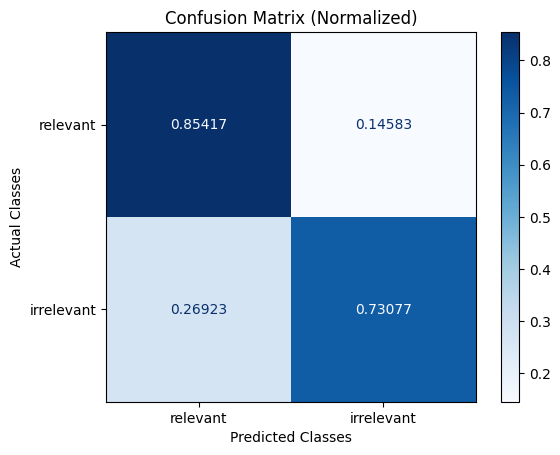

In [24]:
true_labels = df_sample["relevant"].map(RAG_RELEVANCY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Classifications with explanations

When evaluating a dataset for relevance, it can be useful to know why the LLM classified a document as relevant or irrelevant. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [25]:
small_df_sample = df_sample.copy().sample(n=5).reset_index(drop=True)
relevance_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=RAG_RELEVANCY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
    concurrency=20,
)

Using prompt:


You are comparing a reference text to a question and trying to determine if the reference text
contains information relevant to answering the question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {input}
    ************
    [Reference text]: {reference}
    ************
    [END DATA]
Compare the Question above to the Reference text. You must determine whether the Reference text
contains information that can help answer the Question. First, write out in a step by step manner
an EXPLANATION to show how to arrive at the correct answer. Avoid simply stating the correct answer
at the outset. Your response LABEL must be single word, either "relevant" or "irrelevant", and
should not contain any text or characters aside from that word. "irrelevant" means that the
reference text does not help answer to the Question. "relevant" means the reference text directly
answers the question.

Example response:
************
EXPLANATION: An explanation of your reas

llm_classify |          | 0/5 (0.0%) | ⏳ 00:00<? | ?it/s

- Snapped 'relevant' to rail: relevant
- Snapped 'relevant' to rail: relevant
- Snapped 'relevant' to rail: relevant
- Snapped 'irrelevant' to rail: irrelevant
- Snapped 'relevant' to rail: relevant


In [26]:
# Let's view the data
merged_df = pd.merge(
    small_df_sample, relevance_classifications_df, left_index=True, right_index=True
)
merged_df[["input", "reference", "label", "explanation"]].head()

,input,reference,label,explanation
0,who voices quagmire on family guy,"Family Guy creator Seth MacFarlane also provides the voices of Peter Griffin , Stewie Griffin , Brian Griffin , and Glenn Quagmire . Family Guy is an American animated sitcom that features five main voice actors, and numerous regular cast and recurring guest stars. The principal voice cast consists of show creator Seth MacFarlane , Alex Borstein , Seth Green , Mila Kunis (who replaced Lacey Chabert after the first season) and Mike Henry and now, the new actor Beau Osborne. Recurring voice actors include Patrick Warburton , Adam West , John G. Brennan , Nicole Sullivan and Jennifer Tilly , and repeat guest stars include Phyllis Diller , Charles Durning , Rush Limbaugh , and Phil LaMarr . Many cast members provide voices for multiple characters. The voice actors, in portraying the various character personalities on the show, draw inspiration from celebrities and pop culture. Family Guy characters have been played by more than one actor, after members of the show left the series or had conflicting obligations. Kunis was nominated for an Annie Award for voicing Meg Griffin in the season 5 episode "" Barely Legal "" and MacFarlane has also won an Emmy Award for Outstanding Voice-Over Performance and an Annie Award for Best Voice Acting in an Animated Television Production, though no other cast member has won an award for their work on the series.",relevant,"The question asks for the voice actor of the character Quagmire in the animated sitcom Family Guy. The reference text clearly states that Seth MacFarlane, the creator of Family Guy, provides the voice for Glenn Quagmire among other characters. Therefore, the reference text is directly relevant to the question."
1,how many muscles in the human body,"Skeletal muscles homo sapiens This is a table of muscles of the human anatomy . There are approximately 642 skeletal muscles within the typical human, and almost every muscle constitutes one part of a pair of identical bilateral muscles, found on both sides, resulting in approximately 320 pairs of muscles, as presented in this article. Nevertheless, the exact number is difficult to define because different sources group muscles differently, e.g. regarding what is defined as different parts of a single muscle or as several muscles. Examples range from 640 to 850. The muscles of the human body can be categorized into a number of groups which include muscles relating to the head and neck, muscles of the torso or trunk, muscles of the upper limbs, and muscles of the lower limbs. The action refers to the action of each muscle from the standard anatomical position . In other positions, other actions may be performed.",relevant,"The question asks for the number of muscles in the human body. The reference text provides a detailed explanation about the number of muscles in the human body, stating that there are approximately 642 skeletal muscles within the typical human. It also mentions that the exact number is difficult to define because different sources group muscles differently, with examples ranging from 640 to 850. Therefore, the reference text is relevant to the question."
2,what state is tahoe in,"Lake Tahoe (; Washo : dáʔaw) is a large freshwater lake in the Sierra Nevada of the United States. At a surface elevation of , it is located along the border between California and Nevada , west of Carson City . Lake Tahoe is the largest alpine lake in North America. Its depth is , making it the United State's second-deepest (the deepest is Crater Lake in Oregon , being deeper, at ). Additionally, Lake Tahoe is listed as the 26th largest lake by volume in the world at . The lake was formed about 2 million years ago and is a part of the Lake Tahoe Basin with the modern lake being shaped during the ice ages . It is known for the clarity of its water and the panorama of surrounding mountains on all sides. The area surrounding the lake is also referred to as Lake Tahoe, or s

## LLM Evals: relevance Classifications GPT-3.5 Turbo
Run relevance against a subset of the data using GPT-3.5. GPT-3.5 can significantly speed up the classification process. However there are tradeoffs as  we will see below.

In [27]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

In [28]:
rails = list(RAG_RELEVANCY_PROMPT_RAILS_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df_sample,
    template=RAG_RELEVANCY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

    relevant       0.49      0.98      0.65        48
  irrelevant       0.75      0.06      0.11        52

    accuracy                           0.50       100
   macro avg       0.62      0.52      0.38       100
weighted avg       0.62      0.50      0.37       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

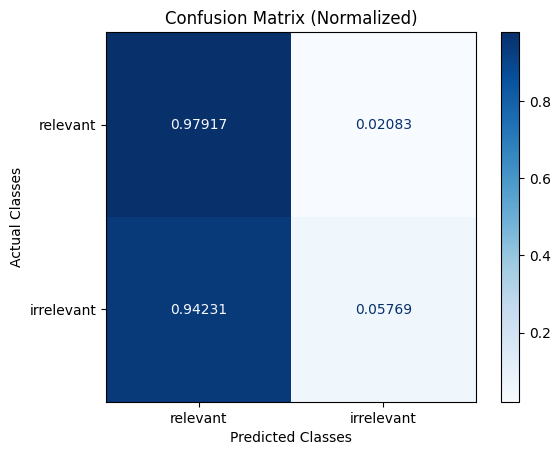

In [29]:
true_labels = df_sample["relevant"].map(RAG_RELEVANCY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Preview: Running with GPT-4 Turbo

In [30]:
model = OpenAIModel(model_name="gpt-4-1106-preview")
relevance_classifications = llm_classify(
    dataframe=df_sample,
    template=RAG_RELEVANCY_PROMPT_TEMPLATE,
    model=model,
    rails=list(RAG_RELEVANCY_PROMPT_RAILS_MAP.values()),
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

    relevant       0.74      0.90      0.81        48
  irrelevant       0.88      0.71      0.79        52

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

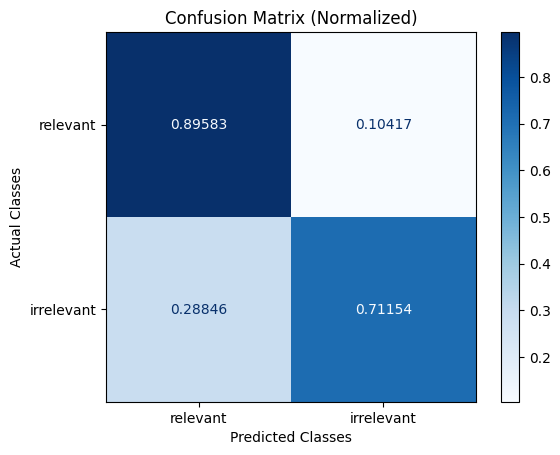

In [31]:
true_labels = df_sample["relevant"].map(RAG_RELEVANCY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)